In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import time
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

%matplotlib inline
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

In [21]:
od.download('https://www.kaggle.com/datasets/wyattowalsh/basketball')

Skipping, found downloaded files in "./basketball" (use force=True to force download)


In [22]:
db_path = './basketball/nba.sqlite'
connection = sqlite3.connect(db_path)

---

# Data Preprocessing

In [2]:
%load_ext sql

%sql sqlite:///basketball/nba.sqlite

In [3]:
# List all tables to verify the table name
tables = %sql SELECT name FROM sqlite_master WHERE type='table';

tables = [table[0] for table in tables]
tables

 * sqlite:///basketball/nba.sqlite
Done.


['game',
 'game_summary',
 'other_stats',
 'officials',
 'inactive_players',
 'game_info',
 'line_score',
 'play_by_play',
 'player',
 'team',
 'common_player_info',
 'team_details',
 'team_history',
 'draft_combine_stats',
 'draft_history',
 'team_info_common']

In [4]:
%%sql

SELECT *
FROM game
LIMIT 5;

 * sqlite:///basketball/nba.sqlite
Done.


season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,ft_pct_home,oreb_home,dreb_home,reb_home,ast_home,stl_home,blk_home,tov_home,pf_home,pts_home,plus_minus_home,video_available_home,team_id_away,team_abbreviation_away,team_name_away,matchup_away,wl_away,fgm_away,fga_away,fg_pct_away,fg3m_away,fg3a_away,fg3_pct_away,ftm_away,fta_away,ft_pct_away,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type
21946,1610610035,HUS,Toronto Huskies,0024600001,1946-11-01 00:00:00,HUS vs. NYK,L,0,25.0,None,None,None,None,None,16.0,29.0,0.552,None,None,None,None,None,None,None,None,66.0,-2,0,1610612752,NYK,New York Knicks,NYK @ HUS,W,24.0,None,None,None,None,None,20.0,26.0,0.769,None,None,None,None,None,None,None,None,68.0,2,0,Regular Season
21946,1610610034,BOM,St. Louis Bombers,0024600003,1946-11-02 00:00:00,BOM vs. PIT,W,0,20.0,59.0,0.339,None,None,None,16.0,None,None,None,None,None,None,None,None,None,21.0,56.0,5,0,1610610031,PIT,Pittsburgh Ironmen,PIT @ BOM,L,16.0,72.0,0.222,None,None,None,19.0,None,None,None,None,None,None,None,None,None,25.0,51.0,-5,0,Regular Season
21946,1610610032,PRO,Providence Steamrollers,0024600002,1946-11-02 00:00:00,PRO vs. BOS,W,0,21.0,None,None,None,None,None,17.0,None,None,None,None,None,None,None,None,None,None,59.0,6,0,1610612738,BOS,Boston Celtics,BOS @ PRO,L,21.0,None,None,None,None,None,11.0,None,None,None,None,None,None,None,None,None,None,53.0,-6,0,Regular Season
21946,1610610025,CHS,Chicago Stags,0024600004,1946-11-02 00:00:00,CHS vs. NYK,W,0,21.0,None,None,None,None,None,21.0,None,None,None,None,None,None,None,None,None,20.0,63.0,16,0,1610612752,NYK,New York Knicks,NYK @ CHS,L,16.0,None,None,None,None,None,15.0,None,None,None,None,None,None,None,None,None,22.0,47.0,-16,0,Regular Season
21946,1610610028,DEF,Detroit Falcons,0024600005,1946-11-02 00:00:00,DEF vs. WAS,L,0,10.0,None,None,None,None,None,13.0,None,None,None,None,None,None,None,None,None,None,33.0,-17,0,1610610036,WAS,Washington Capitols,WAS @ DEF,W,18.0,None,None,None,None,None,14.0,None,None,None,None,None,None,None,None,None,None,50.0,17,0,Regular Season


In [5]:
%%sql

CREATE INDEX idx_game_id ON game(game_id);
CREATE INDEX idx_pbp_game_id ON play_by_play(game_id);
CREATE INDEX idx_officials_game_id ON officials(game_id);

CREATE INDEX idx_team_abbreviation_home ON game(team_abbreviation_home);
CREATE INDEX idx_team_abbreviation_away ON game(team_abbreviation_away);

CREATE INDEX idx_season_id ON game(season_id);

 * sqlite:///basketball/nba.sqlite
(sqlite3.OperationalError) index idx_game_id already exists
[SQL: CREATE INDEX idx_game_id ON game(game_id);]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [7]:
%%sql

SELECT name, tbl_name, sql
FROM sqlite_master
WHERE type = 'index';

 * sqlite:///basketball/nba.sqlite
Done.


name,tbl_name,sql
idx_game_id,game,CREATE INDEX idx_game_id ON game(game_id)
idx_pbp_game_id,play_by_play,CREATE INDEX idx_pbp_game_id ON play_by_play(game_id)
idx_officials_game_id,officials,CREATE INDEX idx_officials_game_id ON officials(game_id)
idx_team_abbreviation_home,game,CREATE INDEX idx_team_abbreviation_home ON game(team_abbreviation_home)
idx_team_abbreviation_away,game,CREATE INDEX idx_team_abbreviation_away ON game(team_abbreviation_away)
idx_season_id,game,CREATE INDEX idx_season_id ON game(season_id)


In [10]:
%%sql dataset_from_sql <<
WITH home_metrics AS 
    (
        SELECT 
            team_abbreviation_home, 
            SUM(fg_pct_home) / COUNT(*) AS season_fg_pct_home, 
            SUM(fg3_pct_home) / COUNT(*) AS season_3pt_pct_home, 
            SUM(tov_home) / COUNT(*) AS season_tov_avg_home, 
            SUM(ast_home) / COUNT(*) AS season_ast_avg_home,
            SUM(ast_home) / SUM(tov_home) AS season_ast_tov_pct_home, 
            SUM(fta_home) / COUNT(*) AS season_avg_fta_game_home, 
            SUM(ft_pct_home) / COUNT(*) AS season_ft_pct_game_home
        FROM game 
        GROUP BY team_abbreviation_home
    ), 
    
    away_metrics AS 
    (
        SELECT 
            team_abbreviation_away, 
            SUM(fg_pct_away) / COUNT(*) AS season_fg_pct_away, 
            SUM(fg3_pct_away) / COUNT(*) AS season_3pt_pct_away, 
            SUM(tov_away) / COUNT(*) AS season_tov_avg_away, 
            SUM(ast_away) / COUNT(*) AS season_ast_avg_away,
            SUM(ast_away) / SUM(tov_away) AS season_ast_tov_pct_away, 
            SUM(fta_away) / COUNT(*) AS season_avg_fta_game_away, 
            SUM(ft_pct_away) / COUNT(*) AS season_ft_pct_game_away
        FROM game
        GROUP BY team_abbreviation_away
    ), 
    
    team_level_metrics AS 
    (
        SELECT 
            hm.team_abbreviation_home, 
            season_fg_pct_home, 
            season_3pt_pct_home, 
            season_tov_avg_home, 
            season_ast_avg_home, 
            season_ast_tov_pct_home, 
            season_avg_fta_game_home, 
            season_ft_pct_game_home,
            season_fg_pct_away, 
            season_3pt_pct_away, 
            season_tov_avg_away, 
            season_ast_avg_away, 
            season_ast_tov_pct_away, 
            season_avg_fta_game_away, 
            season_ft_pct_game_away
        FROM home_metrics hm 
        JOIN away_metrics am ON hm.team_abbreviation_home = am.team_abbreviation_away
    ), 
    
    game_level_metrics AS 
    (
        SELECT 
            pbp.game_id, 
            g.fta_home + g.fta_away AS total_fta, 
            ABS(g.plus_minus_home) AS abs_plus_minus, 
            pts_home + pts_away AS total_points, 
            COUNT(pbp.eventnum) AS total_pbp 
        FROM play_by_play pbp 
        JOIN game g ON pbp.game_id = g.game_id
        GROUP BY pbp.game_id, g.fta_home, g.fta_away
    ), 
    
    officials_metrics AS 
    (
        SELECT 
            o.first_name || '_' || o.last_name AS full_name, 
            COUNT(o.game_id) AS num_of_games, 
            SUM(total_fta) / COUNT(o.game_id) AS avg_fta, 
            SUM(total_points) / COUNT(o.game_id) AS avg_pts_per_game, 
            SUM(abs_plus_minus) / COUNT(o.game_id) AS avg_score_diff, 
            SUM(total_pbp)/COUNT(o.game_id) AS avg_pbp 
        FROM officials o 
        JOIN game_level_metrics pbp ON o.game_id = pbp.game_id 
        GROUP BY full_name
    ), 
    
    split_officials AS 
    (
        SELECT *, 
            first_name || '_' || last_name AS full_name, 
            ROW_NUMBER() OVER(PARTITION BY game_id ORDER BY last_name ASC) AS row_num
        FROM officials 
    ), 
    
    matchup_metrics AS 
    (
        SELECT CASE 
            WHEN team_abbreviation_home > team_abbreviation_away 
            THEN team_abbreviation_away || '_' || team_abbreviation_home 
            ELSE team_abbreviation_home || '_' || team_abbreviation_away 
            END AS matchup, 
                SUM(fg_pct_home + fg_pct_away) / COUNT(*) AS matchup_fg_pct, 
                SUM(fg3_pct_home + fg3_pct_away) / COUNT(*) AS matchup_3pt_pct, 
                SUM(tov_home + tov_away) / COUNT(*) AS matchup_tov_avg, 
                SUM(ast_home + ast_away) / COUNT(*) AS matchup_ast_avg,
                SUM(ast_home + ast_away) / SUM(tov_home + tov_away) AS matchup_ast_tov_pct, 
                SUM(fta_home + fta_away) / COUNT(*) AS matchup_avg_fta_game, 
                SUM(ft_pct_home + ft_pct_away) / COUNT(*) AS matchup_ft_pct_game
        FROM game
        GROUP BY matchup
    )
    
SELECT g.game_id, 
    hm.team_abbreviation_home, hm.season_fg_pct_home, hm.season_3pt_pct_home, hm.season_tov_avg_home, hm.season_ast_avg_home, hm.season_ast_tov_pct_home, hm.season_avg_fta_game_home, hm.season_ft_pct_game_home,
    aw.team_abbreviation_away, aw.season_fg_pct_away, aw.season_3pt_pct_away, aw.season_tov_avg_away, aw.season_ast_avg_away, aw.season_ast_tov_pct_away, aw.season_avg_fta_game_away, aw.season_ft_pct_game_away,
    om_1.full_name AS off_1, om_1.num_of_games AS off_1_num_games, om_1.avg_fta AS off_1_avg_fta, om_1.avg_pts_per_game AS off_1_avg_pts_per_game, om_1.avg_score_diff AS off_1_avg_score_diff, om_1.avg_pbp AS off_1_avg_pbp,
    om_2.full_name AS off_2, om_2.num_of_games AS off_2_num_games, om_2.avg_fta AS off_2_avg_fta, om_2.avg_pts_per_game AS off_2_avg_pts_per_game, om_2.avg_score_diff AS off_2_avg_score_diff, om_2.avg_pbp AS off_2_avg_pbp,
    om_3.full_name AS off_3, om_3.num_of_games AS off_3_num_games, om_3.avg_fta AS off_3_avg_fta, om_3.avg_pts_per_game AS off_3_avg_pts_per_game, om_3.avg_score_diff AS off_3_avg_score_diff, om_3.avg_pbp AS off_3_avg_pbp,
    g.pts_home + g.pts_away AS total_game_points, mm.matchup_fg_pct, mm.matchup_3pt_pct, mm.matchup_tov_avg, mm.matchup_ast_avg, mm.matchup_ast_tov_pct, mm.matchup_avg_fta_game, mm.matchup_ft_pct_game
FROM game g 
    JOIN home_metrics hm ON g.team_abbreviation_home = hm.team_abbreviation_home
    JOIN away_metrics aw ON g.team_abbreviation_away = aw.team_abbreviation_away
    JOIN (SELECT * FROM split_officials WHERE row_num = 1) o_1 ON o_1.game_id = g.game_id
    JOIN (SELECT * FROM split_officials WHERE row_num = 2) o_2 ON o_2.game_id = g.game_id
    JOIN (SELECT * FROM split_officials WHERE row_num = 3) o_3 ON o_3.game_id = g.game_id
    JOIN officials_metrics om_1 ON o_1.full_name = om_1.full_name
    JOIN officials_metrics om_2 ON o_2.full_name = om_2.full_name
    JOIN officials_metrics om_3 ON o_3.full_name = om_3.full_name
    JOIN (
        SELECT g.game_id, 
            CASE WHEN g.team_abbreviation_home > team_abbreviation_away 
            THEN team_abbreviation_away || '_' || team_abbreviation_home 
            ELSE team_abbreviation_home || '_' || team_abbreviation_away 
            END AS matchup 
        FROM game g
        ) match ON g.game_id = match.game_id
    JOIN matchup_metrics mm ON match.matchup = mm.matchup
;

 * sqlite:///basketball/nba.sqlite
Done.
Returning data to local variable dataset_from_sql


In [13]:
df = dataset_from_sql.DataFrame()
df.head(5)

,game_id,team_abbreviation_home,season_fg_pct_home,season_3pt_pct_home,season_tov_avg_home,season_ast_avg_home,season_ast_tov_pct_home,season_avg_fta_game_home,season_ft_pct_game_home,team_abbreviation_away,...,off_3_avg_score_diff,off_3_avg_pbp,total_game_points,matchup_fg_pct,matchup_3pt_pct,matchup_tov_avg,matchup_ast_avg,matchup_ast_tov_pct,matchup_avg_fta_game,matchup_ft_pct_game
0,0012200008,PHX,0.379492,0.255162,10.838438,20.027519,1.847823,27.810919,0.767404,ADL,...,11,465,258.0,1.044000,0.823000,40.000000,57.000000,1.425000,43.000000,1.726000
1,0012200025,OKC,0.466421,0.353922,15.001536,21.847926,1.456379,25.322581,0.769588,ADL,...,11,466,229.0,0.903000,0.806000,23.000000,49.000000,2.130435,51.000000,1.522000
2,0029600188,ORL,0.461923,0.351097,15.039944,22.146461,1.472510,25.920112,0.738282,ATL,...,9,449,154.0,0.902980,0.692846,29.167785,43.557047,1.493327,49.671141,1.486188
3,0049600043,CHI,0.362636,0.252776,10.609598,19.494163,1.837408,26.250324,0.757202,ATL,...,8,474,197.0,0.713648,0.444102,20.709016,35.393443,1.709084,51.696721,1.511176
4,0049600047,CHI,0.362636,0.252776,10.609598,19.494163,1.837408,26.250324,0.757202,ATL,...,11,455,198.0,0.713648,0.444102,20.709016,35.393443,1.709084,51.696721,1.511176


In [14]:
df.shape

(23466, 43)

In [15]:
df.to_csv('nba_data.csv', index=False)

---

# Data Understanding / EDA (Exploratory Data Analysis)

#### Dataset Selection
_Source:_ [kaggle.com/datasets/mirichoi2018/insurance](https://www.kaggle.com/datasets/mirichoi0218/insurance) <br/>
- 30 teams
- 4800+ players
- 65,000+ games (every game since the inaugural 1946-47 NBA season)
- Box Scores for over 95% of all games
- Play-by-Play game data with 13M+ rows

**Preprocessed dataset with SQL:**<br/>
_Number of instances:_ Dataset consists of 1106 rows<br/>
_Features:_ 43 columns <br/>

__Columns:__
- `game_id`: Unique identifier for each game
- `team_abbreviation_home`: Abbreviation of the home team
- `season_fg_pct_home`: Field goal percentage of the home team for the season
- `season_3pt_pct_home`: Three-point field goal percentage of the home team for the season
- `season_tov_avg_home`: Average turnovers per game for the home team for the season
- `season_ast_avg_home`: Average assists per game for the home team for the season
- `season_ast_tov_pct_home`: Assist to turnover ratio for the home team for the season
- `season_avg_fta_game_home`: Average free throw attempts per game for the home team for the season
- `season_ft_pct_game_home`: Free throw percentage for the home team for the season
- `team_abbreviation_away`: Abbreviation of the away team
- `season_fg_pct_away`: Field goal percentage of the away team for the season
- `season_3pt_pct_away`: Three-point field goal percentage of the away team for the season
- `season_tov_avg_away`: Average turnovers per game for the away team for the season
- `season_ast_avg_away`: Average assists per game for the away team for the season
- `season_ast_tov_pct_away`: Assist to turnover ratio for the away team for the season
- `season_avg_fta_game_away`: Average free throw attempts per game for the away team for the season
- `season_ft_pct_game_away`: Free throw percentage for the away team for the season
- `off_1`: Full name of the first official
- `off_1_num_games`: Number of games officiated by the first official
- `off_1_avg_fta`: Average free throw attempts in games officiated by the first official
- `off_1_avg_pts_per_game`: Average points per game in games officiated by the first official
- `off_1_avg_score_diff`: Average score difference in games officiated by the first official
- `off_1_avg_pbp`: Average play-by-play events in games officiated by the first official
- `off_2`: Full name of the second official
- `off_2_num_games`: Number of games officiated by the second official
- `off_2_avg_fta`: Average free throw attempts in games officiated by the second official
- `off_2_avg_pts_per_game`: Average points per game in games officiated by the second official
- `off_2_avg_score_diff`: Average score difference in games officiated by the second official
- `off_2_avg_pbp`: Average play-by-play events in games officiated by the second official
- `off_3`: Full name of the third official
- `off_3_num_games`: Number of games officiated by the third official
- `off_3_avg_fta`: Average free throw attempts in games officiated by the third official
- `off_3_avg_pts_per_game`: Average points per game in games officiated by the third official
- `off_3_avg_score_diff`: Average score difference in games officiated by the third official
- `off_3_avg_pbp`: Average play-by-play events in games officiated by the third official
- `total_game_points`: Total points scored in the game
- `matchup_fg_pct`: Field goal percentage for the matchup
- `matchup_3pt_pct`: Three-point field goal percentage for the matchup
- `matchup_tov_avg`: Average turnovers per game for the matchup
- `matchup_ast_avg`: Average assists per game for the matchup
- `matchup_ast_tov_pct`: Assist to turnover ratio for the matchup
- `matchup_avg_fta_game`: Average free throw attempts per game for the matchup
- `matchup_ft_pct_game`: Free throw percentage for the matchup

#### Problem statement
The goal of this analysis is to understand the impact of various factors on the outcomes of NBA games. Specifically, we aim to investigate how team performance metrics, official performance metrics, and matchup percentages influence the total points scored in a game. By analyzing these factors, we seek to identify patterns and trends that can help predict game outcomes and inform strategic decisions for teams and coaches.

**Question:** Can we predict the total number of points that will be scored in an NBA game using all the game-by-bame historical data available?

#### Objectives

1. **Analyze Team Performance Metrics**: Examine how home and away team performance metrics (e.g., field goal percentage, three-point percentage, turnovers, assists, free throw attempts, and free throw percentage) correlate with the total points scored in a game.

2. **Evaluate Official Performance Metrics**: Assess the influence of game officials on the total points scored by analyzing metrics such as the number of games officiated, average free throw attempts, average points per game, average score difference, and average play-by-play events.

3. **Investigate Matchup Percentages**: Explore how matchup-specific performance metrics (e.g., field goal percentage, three-point percentage, turnovers, assists, free throw attempts, and free throw percentage) affect the total points scored in a game.

4. **Predictive Modeling**: Develop predictive models to forecast the total points scored in a game based on team performance metrics, official performance metrics, and matchup percentages.


In [2]:
df = pd.read_csv('nba_data.csv')
df.head()

,game_id,team_abbreviation_home,season_fg_pct_home,season_3pt_pct_home,season_tov_avg_home,season_ast_avg_home,season_ast_tov_pct_home,season_avg_fta_game_home,season_ft_pct_game_home,team_abbreviation_away,...,off_3_avg_score_diff,off_3_avg_pbp,total_game_points,matchup_fg_pct,matchup_3pt_pct,matchup_tov_avg,matchup_ast_avg,matchup_ast_tov_pct,matchup_avg_fta_game,matchup_ft_pct_game
0,12200008,PHX,0.379492,0.255162,10.838438,20.027519,1.847823,27.810919,0.767404,ADL,...,11,465,258.0,1.044000,0.823000,40.000000,57.000000,1.425000,43.000000,1.726000
1,12200025,OKC,0.466421,0.353922,15.001536,21.847926,1.456379,25.322581,0.769588,ADL,...,11,466,229.0,0.903000,0.806000,23.000000,49.000000,2.130435,51.000000,1.522000
2,29600188,ORL,0.461923,0.351097,15.039944,22.146461,1.472510,25.920112,0.738282,ATL,...,9,449,154.0,0.902980,0.692846,29.167785,43.557047,1.493327,49.671141,1.486188
3,49600043,CHI,0.362636,0.252776,10.609598,19.494163,1.837408,26.250324,0.757202,ATL,...,8,474,197.0,0.713648,0.444102,20.709016,35.393443,1.709084,51.696721,1.511176
4,49600047,CHI,0.362636,0.252776,10.609598,19.494163,1.837408,26.250324,0.757202,ATL,...,11,455,198.0,0.713648,0.444102,20.709016,35.393443,1.709084,51.696721,1.511176


In [3]:
df.describe()

,game_id,season_fg_pct_home,season_3pt_pct_home,season_tov_avg_home,season_ast_avg_home,season_ast_tov_pct_home,season_avg_fta_game_home,season_ft_pct_game_home,season_fg_pct_away,season_3pt_pct_away,...,off_3_avg_score_diff,off_3_avg_pbp,total_game_points,matchup_fg_pct,matchup_3pt_pct,matchup_tov_avg,matchup_ast_avg,matchup_ast_tov_pct,matchup_avg_fta_game,matchup_ft_pct_game
count,2.346600e+04,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000,...,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000
mean,2.203350e+07,0.413258,0.297439,12.540507,20.953250,1.686426,25.817767,0.748599,0.402916,0.290076,...,10.762806,458.372155,205.538439,0.864590,0.636596,27.219751,42.687587,1.583738,49.972364,1.511049
std,5.539128e+06,0.056648,0.056743,2.178818,2.887607,0.137304,1.520139,0.025265,0.054937,0.055737,...,0.622738,5.229157,24.099400,0.096983,0.108904,4.171236,5.205499,0.149845,3.404459,0.039128
min,1.050000e+07,0.278977,0.148071,8.288732,13.664161,0.806452,0.666667,0.333333,0.275001,0.118000,...,3.000000,425.000000,69.000000,0.405623,0.253250,11.519337,19.714563,0.723404,9.666667,0.872000
25%,2.070025e+07,0.376035,0.252776,10.838438,19.494163,1.577632,24.858961,0.746404,0.365871,0.244235,...,10.000000,456.000000,189.000000,0.863750,0.578405,24.769231,41.089286,1.484549,48.072464,1.496453
50%,2.130082e+07,0.442634,0.313779,12.330421,21.737589,1.689946,25.823347,0.755107,0.436127,0.306750,...,11.000000,458.000000,204.000000,0.905494,0.683985,28.759259,43.750000,1.564327,50.053571,1.513132
75%,2.180110e+07,0.461923,0.351097,14.627184,23.017437,1.798878,26.829462,0.762943,0.449481,0.341504,...,11.000000,463.000000,221.000000,0.917794,0.709864,30.032520,45.898148,1.675558,52.149425,1.529215
max,4.960009e+07,0.586333,0.405500,31.000000,47.000000,3.833333,35.500000,0.875000,0.618000,0.517000,...,17.000000,541.000000,374.000000,1.142667,1.073000,57.000000,89.000000,3.448000,86.000000,1.784000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23466 entries, 0 to 23465
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   game_id                   23466 non-null  int64  
 1   team_abbreviation_home    23466 non-null  object 
 2   season_fg_pct_home        23466 non-null  float64
 3   season_3pt_pct_home       23466 non-null  float64
 4   season_tov_avg_home       23466 non-null  float64
 5   season_ast_avg_home       23466 non-null  float64
 6   season_ast_tov_pct_home   23466 non-null  float64
 7   season_avg_fta_game_home  23466 non-null  float64
 8   season_ft_pct_game_home   23466 non-null  float64
 9   team_abbreviation_away    23466 non-null  object 
 10  season_fg_pct_away        23466 non-null  float64
 11  season_3pt_pct_away       23466 non-null  float64
 12  season_tov_avg_away       23466 non-null  float64
 13  season_ast_avg_away       23466 non-null  float64
 14  season

In [5]:
df.shape

(23466, 43)

#### Number of missing values

In [ ]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

### Data Visualization

<Axes: xlabel='total_game_points', ylabel='Count'>

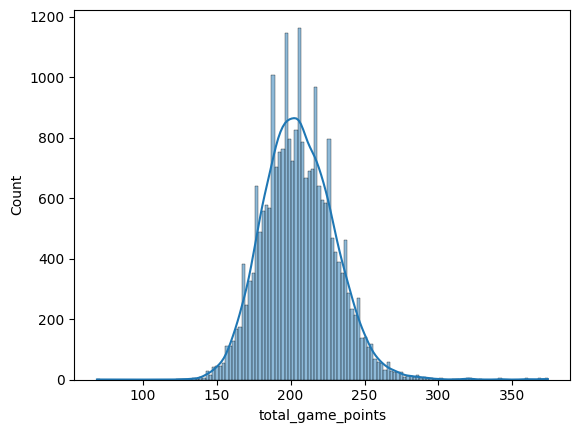

In [7]:
sns.histplot(df['total_game_points'], kde=True)

In [8]:
columns_to_drop = ['game_id', 'team_abbreviation_home', 'team_abbreviation_away', 'off_1', 'off_2', 'off_3']

#### Feature histograms

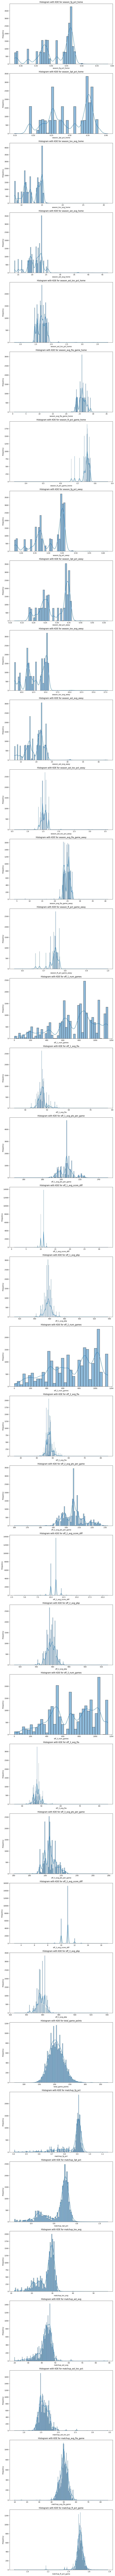

In [23]:
numerical_columns = df.copy().drop(columns=columns_to_drop).select_dtypes(include=[np.number]).columns
num_columns = len(numerical_columns)
fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(10, 6 * num_columns))

for ax, column in zip(axes, numerical_columns):
    sns.histplot(df[column], kde=True, ax=ax)
    ax.set_title(f'Histogram with KDE for {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Correlation Matrix

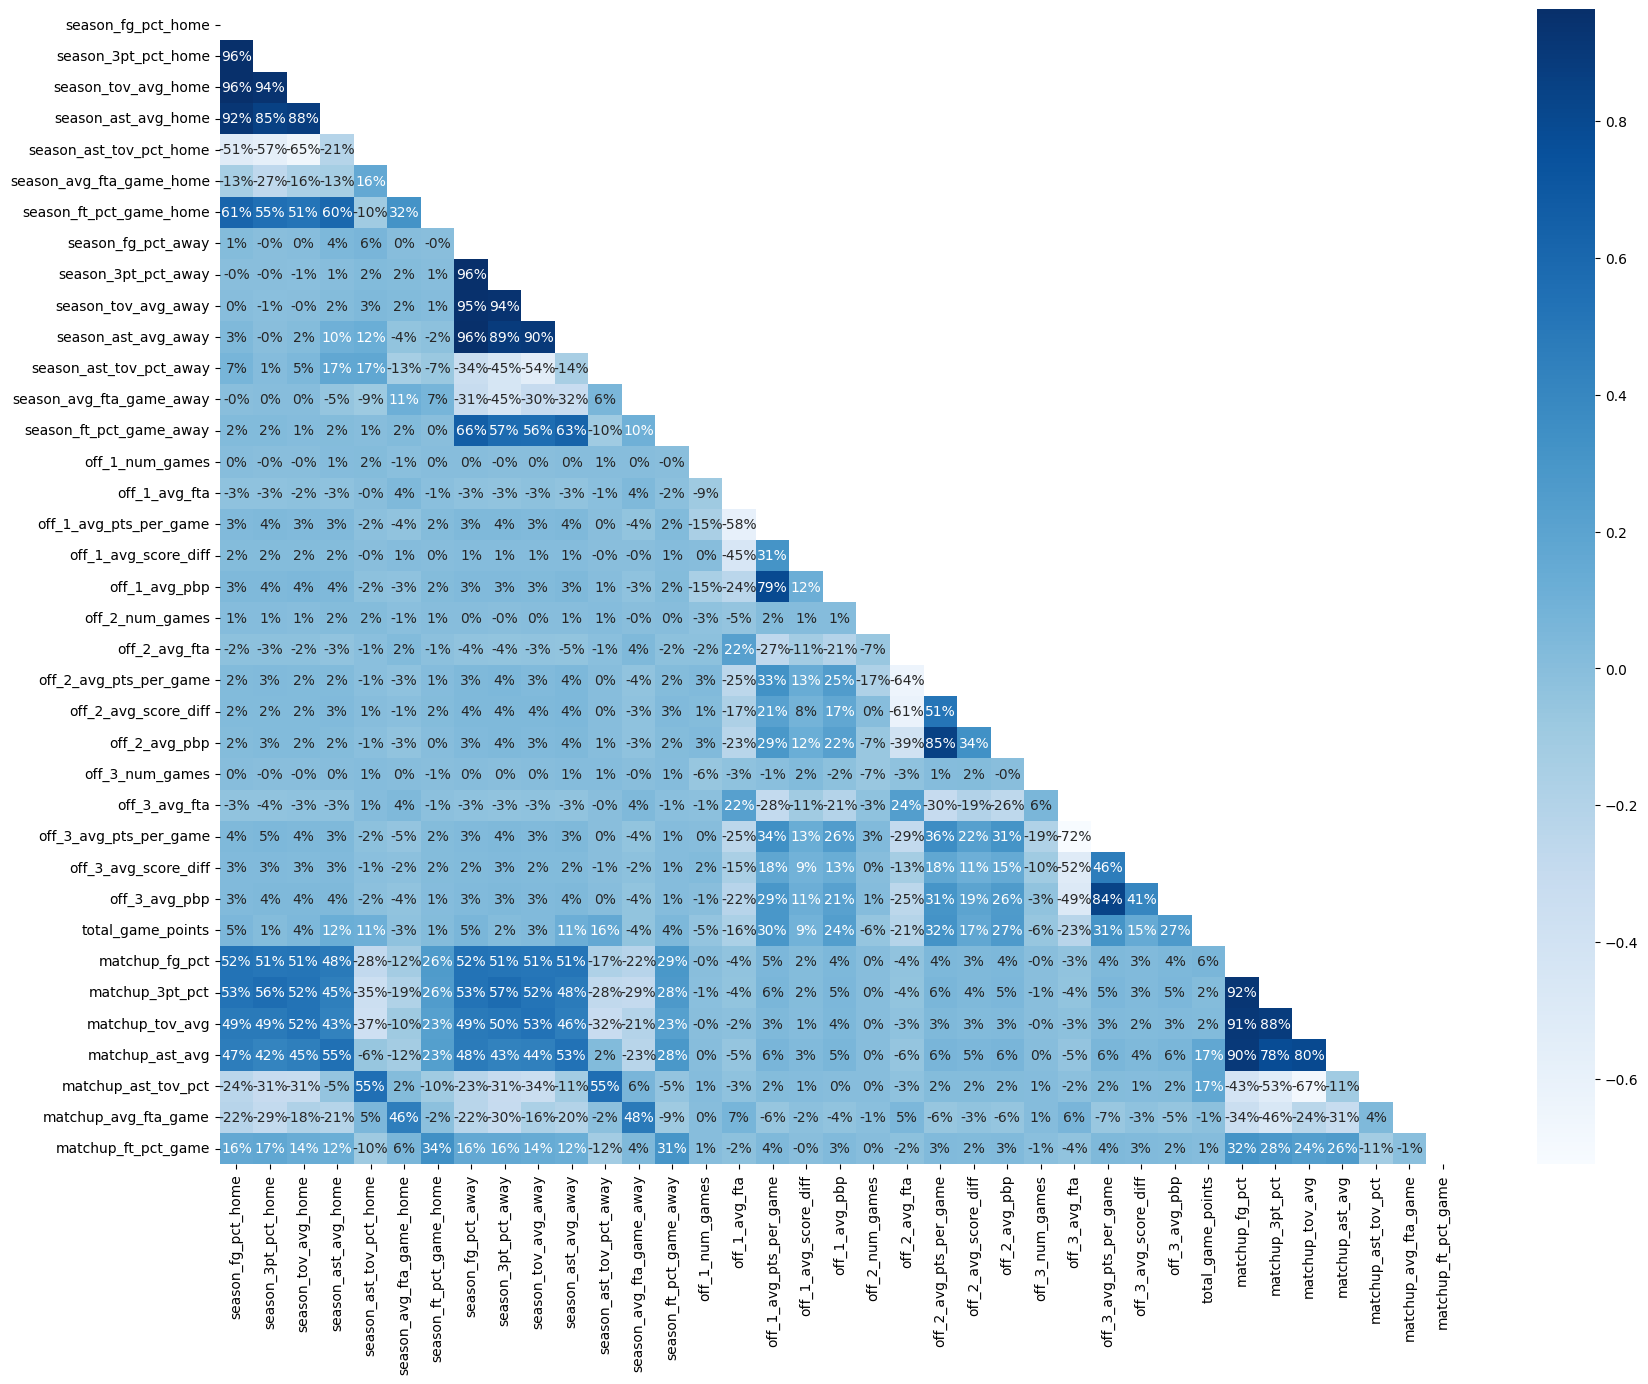

In [24]:
df_mx = df.copy().drop(columns=columns_to_drop).corr()

mask = np.triu(np.ones_like(df_mx, dtype=bool))
plt.figure(figsize=(20, 15))
sns.heatmap(df_mx, mask=mask, annot=True, cmap='Blues', fmt='.0%')
plt.show()

---

# Feature Selection / Reduction

When dealing with many features (especially with potential overlap, e.g. correlated stats), feature selection can help:

Reduce overfitting risk by removing redundant or noisy features.
Improve model interpretability by focusing on the most important predictors.
Decrease computational cost and training time.
Potentially improve model performance (less risk of “noise” overshadowing true signals).
In this dataset, we have dozens of numeric features describing team stats, officials’ averages, and matchup-level stats. We might suspect that certain features carry redundant information (e.g., strong correlations among different shooting percentages or assist/turnover ratios).

In [7]:
target_col = 'total_game_points'

# Columns to drop from features (e.g. IDs, text columns)
drop_cols = [
    'game_id',
    'team_abbreviation_home',
    'team_abbreviation_away',
    'off_1', 'off_2', 'off_3',
    target_col
]

# Create X and y
X = df.drop(columns=drop_cols)
y = df[target_col]

print("Feature Matrix shape:", X.shape)
print("Target Vector shape:", y.shape)


Feature Matrix shape: (23466, 36)
Target Vector shape: (23466,)


### SelectKBest

In [8]:
# We'll use a simple linear regressor for illustration
base_estimator = LinearRegression()

k_values = [5, 10, 15, 20]
results_selectk = {}

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    # Transform X
    X_new = selector.fit_transform(X, y)
    
    # Evaluate via cross-validation
    scores = cross_val_score(base_estimator, X_new, y, cv=5, scoring='neg_mean_squared_error')
    results_selectk[k] = np.mean(scores)

print("SelectKBest results (mean CV MSE * -1):")
for k, score in results_selectk.items():
    print(f"  k={k}, Mean CV MSE = {-score:.2f}")

# If you want to see which features get selected for the best k:
best_k = max(results_selectk, key=results_selectk.get)  # picking best MSE
selector_best = SelectKBest(score_func=f_regression, k=best_k)
selector_best.fit(X, y)

selected_mask = selector_best.get_support()
selected_features_kbest = X.columns[selected_mask]
print(f"\nBest K={best_k} features:", selected_features_kbest.tolist())


SelectKBest results (mean CV MSE * -1):
  k=5, Mean CV MSE = 482.85
  k=10, Mean CV MSE = 469.72
  k=15, Mean CV MSE = 452.11
  k=20, Mean CV MSE = 448.74

Best K=20 features: ['season_ast_avg_home', 'season_ast_tov_pct_home', 'season_ast_avg_away', 'season_ast_tov_pct_away', 'off_1_avg_fta', 'off_1_avg_pts_per_game', 'off_1_avg_score_diff', 'off_1_avg_pbp', 'off_2_num_games', 'off_2_avg_fta', 'off_2_avg_pts_per_game', 'off_2_avg_score_diff', 'off_2_avg_pbp', 'off_3_num_games', 'off_3_avg_fta', 'off_3_avg_pts_per_game', 'off_3_avg_score_diff', 'off_3_avg_pbp', 'matchup_ast_avg', 'matchup_ast_tov_pct']


### Lasso

In [9]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 50]
}

lasso = Lasso(max_iter=10000, random_state=42)
grid_search = GridSearchCV(
    estimator=lasso, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=5
)
grid_search.fit(X, y)

print("Best Lasso alpha:", grid_search.best_params_)
print("Best CV score (MSE * -1):", -grid_search.best_score_)

best_lasso = grid_search.best_estimator_

# Check which coefficients are non-zero
lasso_coeffs = pd.Series(best_lasso.coef_, index=X.columns)
selected_features_lasso = lasso_coeffs[lasso_coeffs != 0].index
print("\nFeatures selected by Lasso:", selected_features_lasso.tolist())


Best Lasso alpha: {'alpha': 0.001}
Best CV score (MSE * -1): 442.2321603038454

Features selected by Lasso: ['season_fg_pct_home', 'season_3pt_pct_home', 'season_tov_avg_home', 'season_ast_avg_home', 'season_avg_fta_game_home', 'season_ft_pct_game_home', 'season_fg_pct_away', 'season_3pt_pct_away', 'season_tov_avg_away', 'season_ast_avg_away', 'season_ast_tov_pct_away', 'season_avg_fta_game_away', 'season_ft_pct_game_away', 'off_1_num_games', 'off_1_avg_fta', 'off_1_avg_pts_per_game', 'off_1_avg_score_diff', 'off_1_avg_pbp', 'off_2_num_games', 'off_2_avg_fta', 'off_2_avg_pts_per_game', 'off_2_avg_score_diff', 'off_2_avg_pbp', 'off_3_num_games', 'off_3_avg_fta', 'off_3_avg_pts_per_game', 'off_3_avg_score_diff', 'off_3_avg_pbp', 'matchup_fg_pct', 'matchup_3pt_pct', 'matchup_tov_avg', 'matchup_ast_avg', 'matchup_ast_tov_pct', 'matchup_avg_fta_game', 'matchup_ft_pct_game']


### RFECV

In [10]:
lr = LinearRegression()

rfecv = RFECV(
    estimator=lr, 
    step=1,  
    cv=5,  
    scoring='neg_mean_squared_error'
)
rfecv.fit(X, y)

print("Optimal number of features:", rfecv.n_features_)


Optimal number of features: 36


In [11]:
# Retrieve the mean CV scores using the new key
mean_test_scores = rfecv.cv_results_['mean_test_score']  # 1D array for each candidate feature count
best_score = mean_test_scores[rfecv.n_features_ - 1]  # index corresponds to the optimal number of features

print(f"Best CV score (MSE * -1): {-best_score:.4f}")


selected_mask = rfecv.support_
selected_features_rfecv = X.columns[selected_mask]
print("Features selected by RFECV:", selected_features_rfecv.tolist())

Best CV score (MSE * -1): 442.1586
Features selected by RFECV: ['season_fg_pct_home', 'season_3pt_pct_home', 'season_tov_avg_home', 'season_ast_avg_home', 'season_ast_tov_pct_home', 'season_avg_fta_game_home', 'season_ft_pct_game_home', 'season_fg_pct_away', 'season_3pt_pct_away', 'season_tov_avg_away', 'season_ast_avg_away', 'season_ast_tov_pct_away', 'season_avg_fta_game_away', 'season_ft_pct_game_away', 'off_1_num_games', 'off_1_avg_fta', 'off_1_avg_pts_per_game', 'off_1_avg_score_diff', 'off_1_avg_pbp', 'off_2_num_games', 'off_2_avg_fta', 'off_2_avg_pts_per_game', 'off_2_avg_score_diff', 'off_2_avg_pbp', 'off_3_num_games', 'off_3_avg_fta', 'off_3_avg_pts_per_game', 'off_3_avg_score_diff', 'off_3_avg_pbp', 'matchup_fg_pct', 'matchup_3pt_pct', 'matchup_tov_avg', 'matchup_ast_avg', 'matchup_ast_tov_pct', 'matchup_avg_fta_game', 'matchup_ft_pct_game']


### Combining the results of SelectKBest, Lasso, and RFECV methods

In [12]:
all_selected_sets = {
    "SelectKBest": set(selected_features_kbest),
    "Lasso": set(selected_features_lasso),
    "RFECV": set(selected_features_rfecv)
}


common_features = set.intersection(*all_selected_sets.values())
union_features  = set.union(*all_selected_sets.values())

print("Features chosen by ALL methods:", common_features)
print("Features chosen by ANY method:", union_features)


Features chosen by ALL methods: {'off_2_avg_fta', 'off_1_avg_pts_per_game', 'off_2_avg_score_diff', 'matchup_ast_avg', 'off_1_avg_score_diff', 'season_ast_avg_away', 'off_3_avg_pbp', 'off_1_avg_fta', 'off_2_avg_pts_per_game', 'off_3_avg_score_diff', 'off_3_avg_pts_per_game', 'season_ast_tov_pct_away', 'off_2_avg_pbp', 'off_3_num_games', 'off_2_num_games', 'matchup_ast_tov_pct', 'season_ast_avg_home', 'off_3_avg_fta', 'off_1_avg_pbp'}
Features chosen by ANY method: {'off_2_avg_fta', 'season_3pt_pct_away', 'off_1_avg_pts_per_game', 'off_2_avg_score_diff', 'matchup_ast_avg', 'matchup_avg_fta_game', 'off_1_avg_score_diff', 'season_ast_avg_away', 'season_fg_pct_away', 'matchup_3pt_pct', 'season_avg_fta_game_away', 'off_3_avg_pbp', 'season_tov_avg_home', 'season_ft_pct_game_home', 'off_1_num_games', 'matchup_tov_avg', 'off_1_avg_fta', 'off_2_avg_pts_per_game', 'season_ft_pct_game_away', 'season_3pt_pct_home', 'matchup_ft_pct_game', 'off_3_avg_score_diff', 'season_avg_fta_game_home', 'off_3_a

Columns to drop (not chosen by ALL methods):

In [13]:
columns_to_drop = union_features - common_features
print("Columns to drop (not chosen by ALL methods):", columns_to_drop)
print("Number of columns to drop:", len(columns_to_drop))


Columns to drop (not chosen by ALL methods): {'matchup_3pt_pct', 'season_avg_fta_game_away', 'season_3pt_pct_away', 'season_3pt_pct_home', 'season_ast_tov_pct_home', 'season_tov_avg_home', 'season_ft_pct_game_home', 'off_1_num_games', 'matchup_tov_avg', 'matchup_fg_pct', 'season_avg_fta_game_home', 'matchup_avg_fta_game', 'season_fg_pct_away', 'season_fg_pct_home', 'season_tov_avg_away', 'season_ft_pct_game_away', 'matchup_ft_pct_game'}
Number of columns to drop: 17


Remaining Features:

In [14]:
X_reduced = X.drop(columns=columns_to_drop)
print("Remaining features:", X_reduced.columns.tolist())
print("Number of features:", X_reduced.columns.size)

Remaining features: ['season_ast_avg_home', 'season_ast_avg_away', 'season_ast_tov_pct_away', 'off_1_avg_fta', 'off_1_avg_pts_per_game', 'off_1_avg_score_diff', 'off_1_avg_pbp', 'off_2_num_games', 'off_2_avg_fta', 'off_2_avg_pts_per_game', 'off_2_avg_score_diff', 'off_2_avg_pbp', 'off_3_num_games', 'off_3_avg_fta', 'off_3_avg_pts_per_game', 'off_3_avg_score_diff', 'off_3_avg_pbp', 'matchup_ast_avg', 'matchup_ast_tov_pct']
Number of features: 19


**Feature Reduction Decision**

After applying three different feature selection methods (SelectKBest, Lasso, and RFECV), we identified a set of features that were consistently selected by all methods. The features that were not chosen by all methods were decided to be removed to reduce redundancy and potential noise in the dataset. This step helps in:

- **Reducing Overfitting**: By eliminating less important features, we decrease the risk of the model capturing noise instead of true patterns.
- **Improving Interpretability**: Focusing on a smaller set of significant features makes the model easier to understand and interpret.
- **Enhancing Computational Efficiency**: Fewer features lead to faster training times and lower computational costs.

The columns removed were those not chosen by all three methods, ensuring that only the most relevant features were retained for model building.

---

# Model Building / Selection

What are the baseline and target (estimators) among your estimators? (The baseline will be chosen from linear models, and the target from your Ref. paper(s))

Using covered all the methods. At least 6 categories/types of 
1. Linear Models (LR, Poly-LR / LDA), 
2. with Regularization (Ridge / Lasso) methods; 
3. Tree-based models; 
4. Ensemble (bagging and boosting) 
5. SVM 
6. kNN

Requirement: At least 8-9 estimators

--

Systematic Cross-Validation.
Requirements: 
1. a Search Space Table for hyper-parameters (HP), 
2. HP priority (or Global search),  
3. selection with  a local optimal point for each HP comparing training and validation errors (scores) in each estimator, 
4. the total training time of each estimator for all HPs, and 
5. the best among all the estimators w.r.t Val.

--

For the CVs, fully visualized improving readability? (Requirement: a local optimal point (not coninuous), comparing training and validation errors)

--

model comparison, analyses, and  selection with the best validation results (and next steps, if any)? Takeaways (overall conclusions in training phase)



In [15]:
models_and_params = {
    "LinearRegression": {
        "model": LinearRegression(),
        "params": {
            # no major hyperparams for basic LR
        }
    },
    "PolynomialLinear": {
        # Use a pipeline to combine polynomial expansion with linear regression
        "model": Pipeline([
            ("poly", PolynomialFeatures()), 
            ("linreg", LinearRegression())
        ]),
        "params": {
            "poly__degree": [1, 2, 3]  # polynomial degrees
        }
    },
    "Ridge": {
        "model": Ridge(random_state=42),
        "params": {
            "alpha": [0.01, 0.1, 1, 10]
        }
    },
    "Lasso": {
        "model": Lasso(max_iter=5000, random_state=42),
        "params": {
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "max_depth": [3, 5, 7],
            "min_samples_split": [2, 5, 10]
        }
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "min_samples_leaf": [1, 2, 5]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ['rbf', 'poly'],
            "gamma": ['scale', 'auto']
        }
    },
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ['uniform', 'distance']
        }
    }
}

In [ ]:
results = []
best_estimators = {}

X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, 
    y, 
    test_size=0.2,    # 20% goes to test set
    random_state=42   # for reproducibility
)

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

for model_name, mp in models_and_params.items():
    estimator = mp["model"]
    param_grid = mp["params"]

    start_time = time.time()
    
    grid = GridSearchCV(estimator=estimator,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=5, 
                        n_jobs=-1)
    grid.fit(X_train, y_train)
    
    end_time = time.time()
    training_duration = end_time - start_time
    
    best_estimators[model_name] = grid.best_estimator_
    best_score = -grid.best_score_  # Because we used neg MSE
    
    results.append({
        "model": model_name,
        "best_params": grid.best_params_,
        "best_cv_mse": best_score,
        "training_time_sec": training_duration
    })

results_df = pd.DataFrame(results).sort_values(by="best_cv_mse")
results_df

Shapes:
X_train: (18772, 19)
y_train: (18772,)
X_test: (4694, 19)
y_test: (4694,)


Model Comparison Results:
              model                                        best_params  \
0             Ridge                                     {'alpha': 0.1}   
1             Lasso                                   {'alpha': 0.001}   
2  PolynomialLinear                                {'poly__degree': 1}   
3  LinearRegression                                                 {}   
4      RandomForest  {'max_depth': 5, 'min_samples_leaf': 5, 'n_est...   
5  GradientBoosting  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
6               SVR      {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}   
7               KNN           {'n_neighbors': 7, 'weights': 'uniform'}   
8      DecisionTree           {'max_depth': 3, 'min_samples_split': 2}   

   best_cv_mse  training_time_sec  
0   282.355185           0.041874  
1   282.363361           0.050699  
2   282.364894           0.851434  
3   282.364894           1.031436  
4   305.733545           1.821930  
5   310.017115   

/tmp/ipykernel_1298794/1231506712.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="model", y="best_cv_mse", data=results_df, palette="viridis")


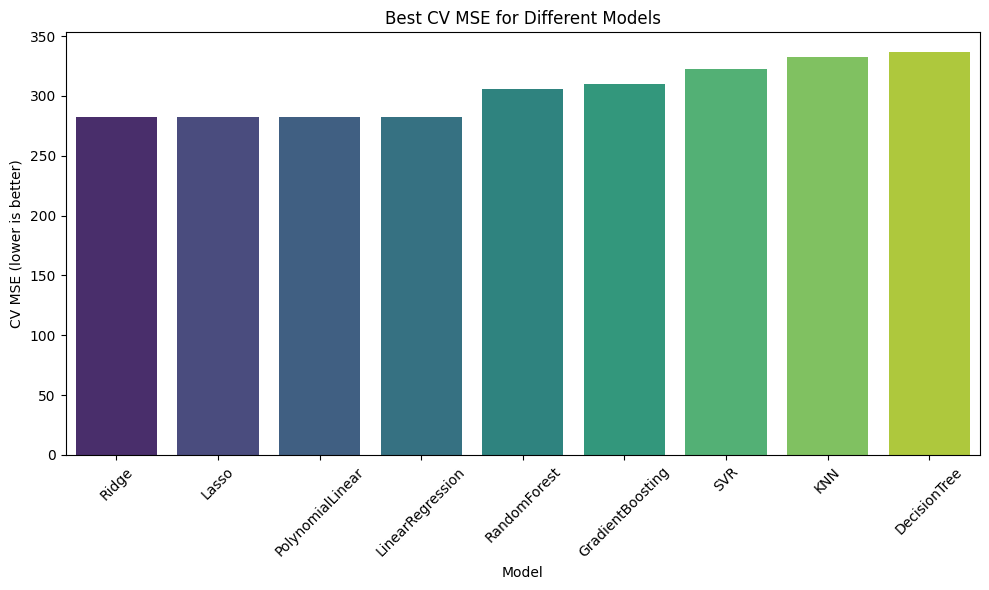

/tmp/ipykernel_1298794/1231506712.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="model", y="training_time_sec", data=results_df, palette="coolwarm")


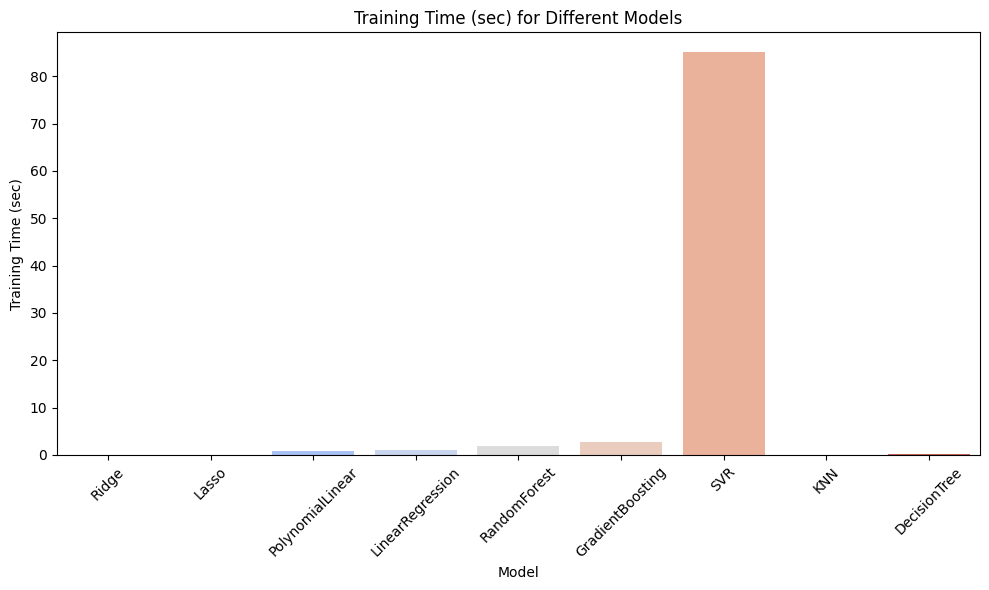

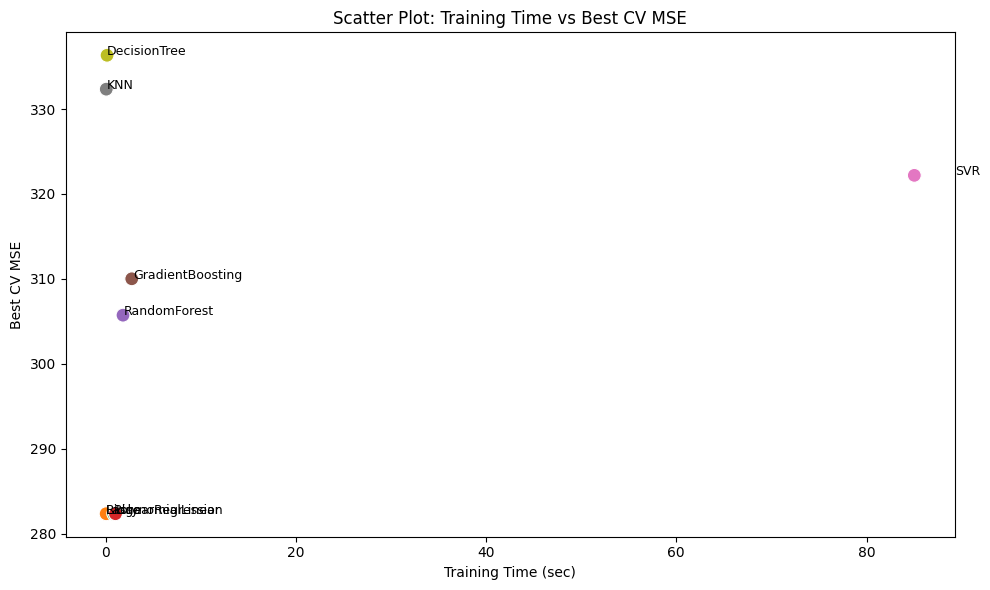

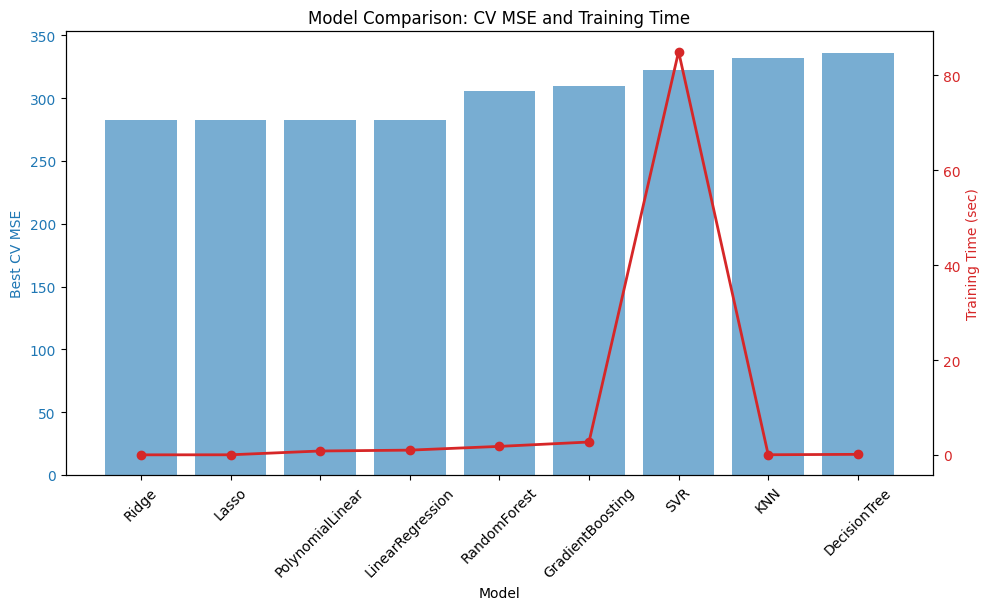

In [ ]:
# Assume results_df has been defined as before:
results_df = pd.DataFrame([
    {"model": "Ridge", "best_params": "{'alpha': 0.1}", "best_cv_mse": 282.355185, "training_time_sec": 0.041874},
    {"model": "Lasso", "best_params": "{'alpha': 0.001}", "best_cv_mse": 282.363361, "training_time_sec": 0.050699},
    {"model": "PolynomialLinear", "best_params": "{'poly__degree': 1}", "best_cv_mse": 282.364894, "training_time_sec": 0.851434},
    {"model": "LinearRegression", "best_params": "{}", "best_cv_mse": 282.364894, "training_time_sec": 1.031436},
    {"model": "RandomForest", "best_params": "{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}", "best_cv_mse": 305.733545, "training_time_sec": 1.821930},
    {"model": "GradientBoosting", "best_params": "{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}", "best_cv_mse": 310.017115, "training_time_sec": 2.742846},
    {"model": "SVR", "best_params": "{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}", "best_cv_mse": 322.191786, "training_time_sec": 85.025876},
    {"model": "KNN", "best_params": "{'n_neighbors': 7, 'weights': 'uniform'}", "best_cv_mse": 332.335528, "training_time_sec": 0.061471},
    {"model": "DecisionTree", "best_params": "{'max_depth': 3, 'min_samples_split': 2}", "best_cv_mse": 336.326479, "training_time_sec": 0.144896}
])

# Sort the results by best_cv_mse (lowest is best)
results_df = results_df.sort_values(by="best_cv_mse", ascending=True)
print("Model Comparison Results:")
print(results_df)

# -------------------------------
# Visualization 1: Bar Plot for Best CV MSE
plt.figure(figsize=(10,6))
sns.barplot(x="model", y="best_cv_mse", data=results_df, palette="viridis")
plt.title("Best CV MSE for Different Models")
plt.ylabel("CV MSE (lower is better)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# Visualization 2: Bar Plot for Training Time
plt.figure(figsize=(10,6))
sns.barplot(x="model", y="training_time_sec", data=results_df, palette="coolwarm")
plt.title("Training Time (sec) for Different Models")
plt.ylabel("Training Time (sec)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# Visualization 3: Scatter Plot - Training Time vs Best CV MSE
plt.figure(figsize=(10,6))
sns.scatterplot(x="training_time_sec", y="best_cv_mse", data=results_df, s=100, hue="model", palette="tab10", legend=False)
# Annotate each point with the model name
for i in range(results_df.shape[0]):
    plt.text(results_df.training_time_sec.iloc[i]*1.05, results_df.best_cv_mse.iloc[i], 
             results_df.model.iloc[i], fontsize=9)
plt.xlabel("Training Time (sec)")
plt.ylabel("Best CV MSE")
plt.title("Scatter Plot: Training Time vs Best CV MSE")
plt.tight_layout()
plt.show()

# -------------------------------
# Visualization 4: Dual-Axis Plot for CV MSE and Training Time
fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Best CV MSE', color=color)
ax1.bar(results_df.model, results_df.best_cv_mse, color=color, alpha=0.6, label="Best CV MSE")
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

ax2 = ax1.twinx()  # instantiate a second axes sharing the same x-axis
color = 'tab:red'
ax2.set_ylabel('Training Time (sec)', color=color)  
ax2.plot(results_df.model, results_df.training_time_sec, color=color, marker="o", linewidth=2, label="Training Time")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # Ensure the right y-label is not clipped
plt.title("Model Comparison: CV MSE and Training Time")
plt.show()


In [ ]:
results = []
best_estimators = {}
training_vs_validation = {}  # To store train/validation scores per model

for model_name, mp in models_and_params.items():
    estimator = mp["model"]
    param_grid = mp["params"]

    start_time = time.time()
    
    grid = GridSearchCV(estimator=estimator,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=5, 
                        return_train_score=True,  # ✅ Enables train-validation score tracking
                        n_jobs=-1)
    grid.fit(X_train, y_train)
    
    end_time = time.time()
    training_duration = end_time - start_time
    
    best_estimators[model_name] = grid.best_estimator_
    best_score = -grid.best_score_  # Convert neg MSE back to positive

    # Store scores for visualization
    training_vs_validation[model_name] = {
        "train_scores": -grid.cv_results_["mean_train_score"],  # Convert neg MSE
        "val_scores": -grid.cv_results_["mean_test_score"],     # Convert neg MSE
        "params": grid.cv_results_["params"]
    }

    results.append({
        "model": model_name,
        "best_params": grid.best_params_,
        "best_cv_mse": best_score,
        "training_time_sec": training_duration
    })

results_df = pd.DataFrame(results).sort_values(by="best_cv_mse")


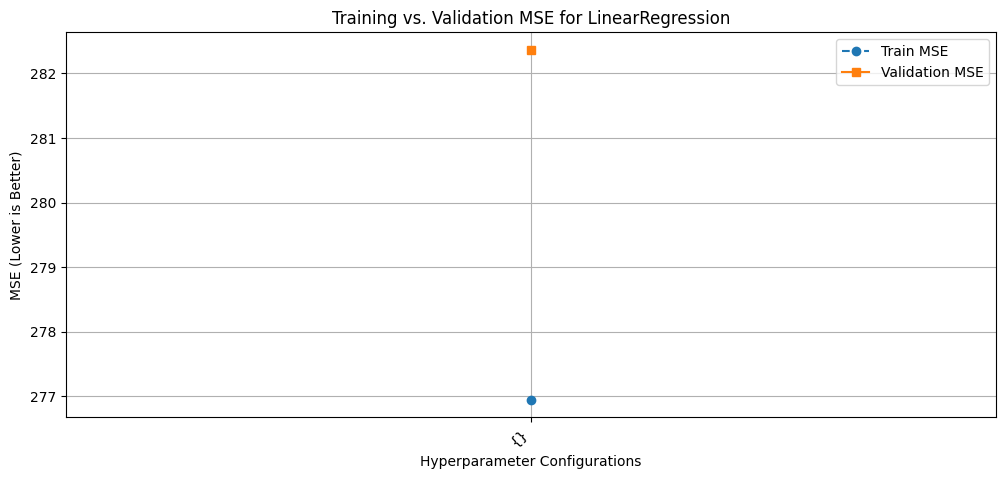

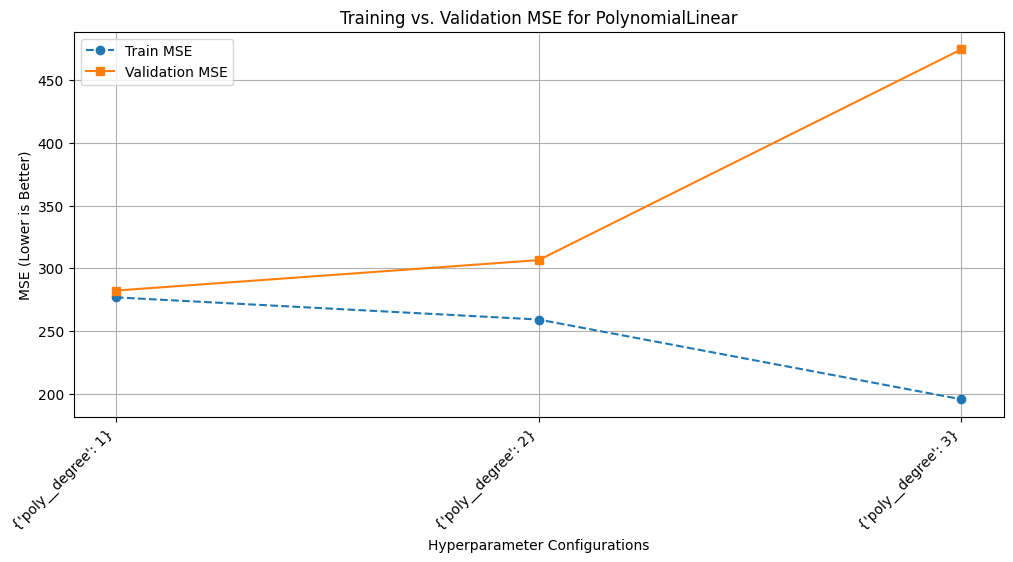

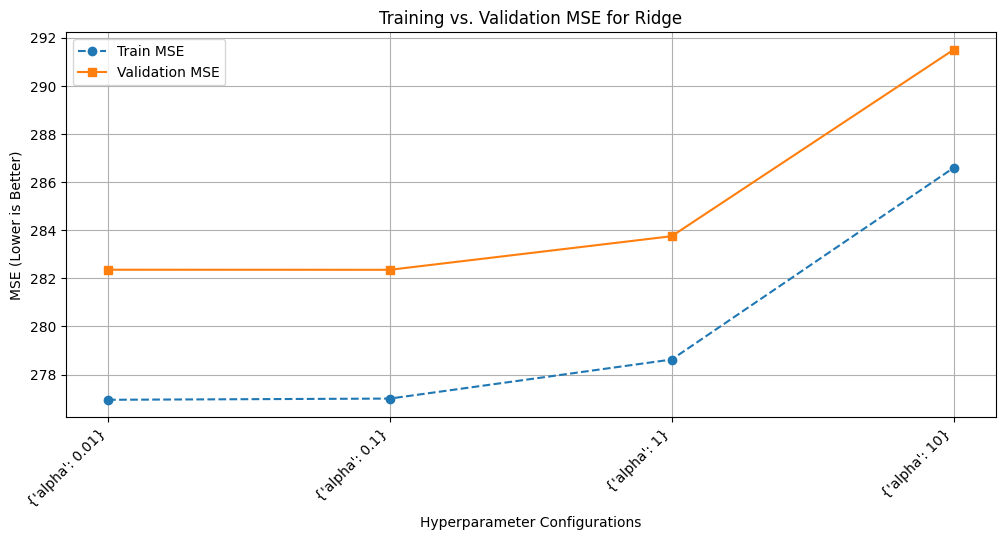

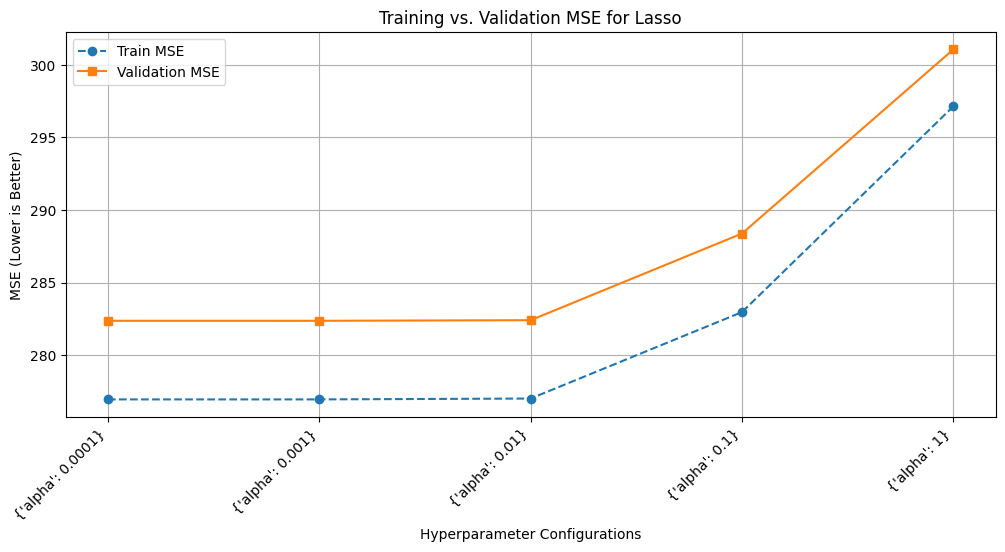

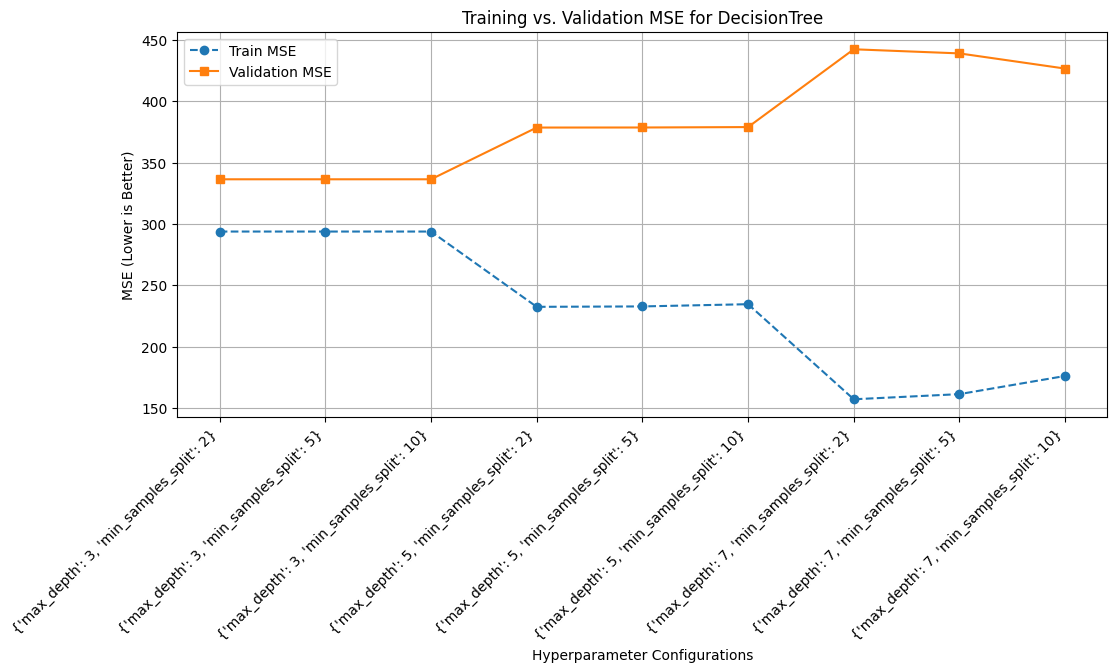

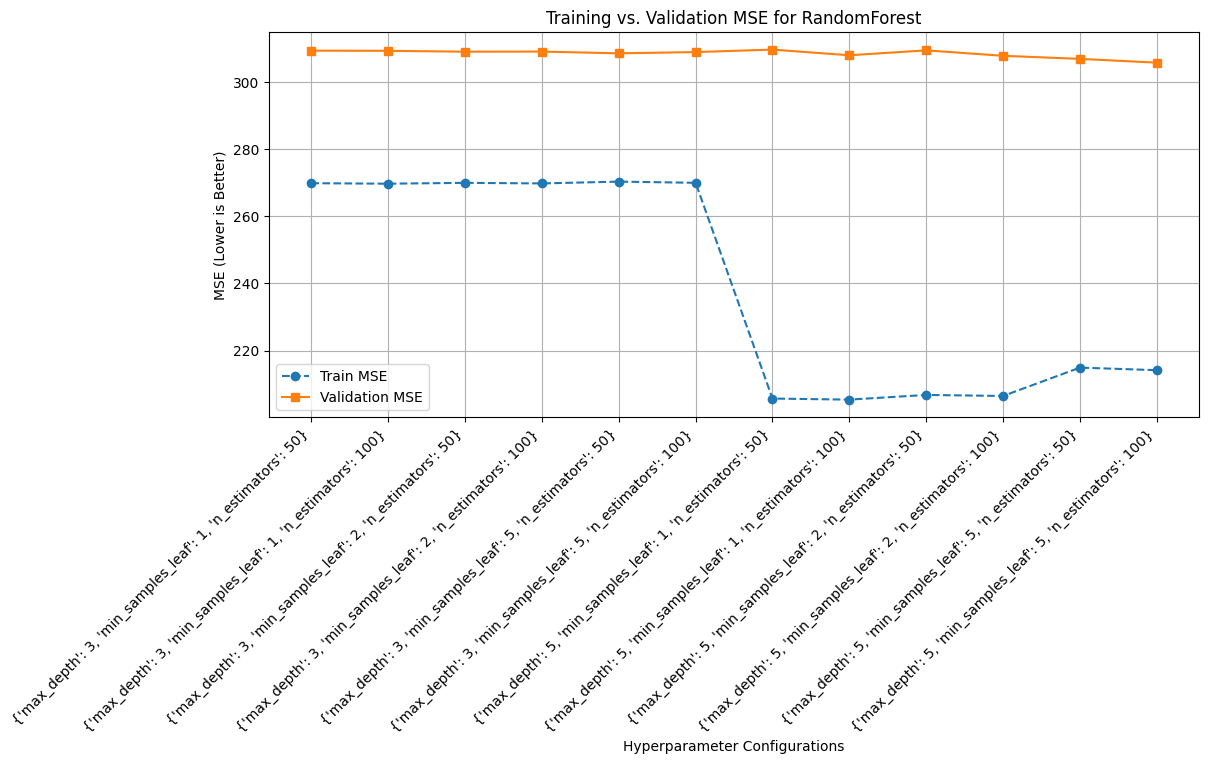

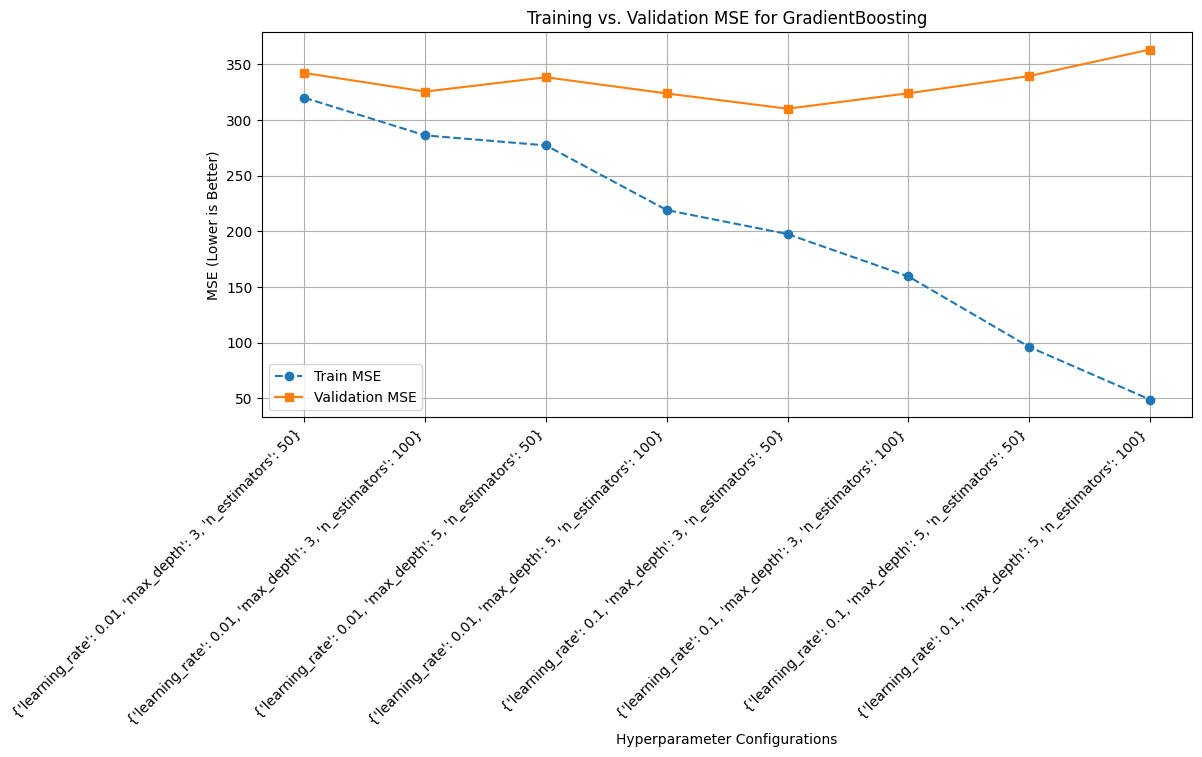

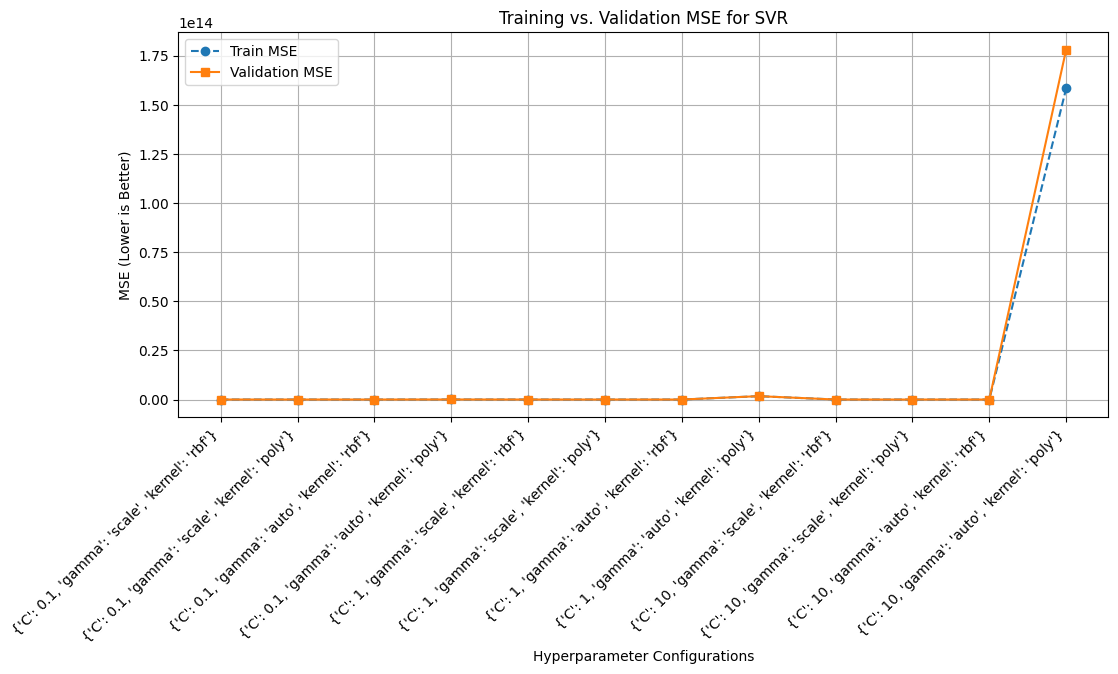

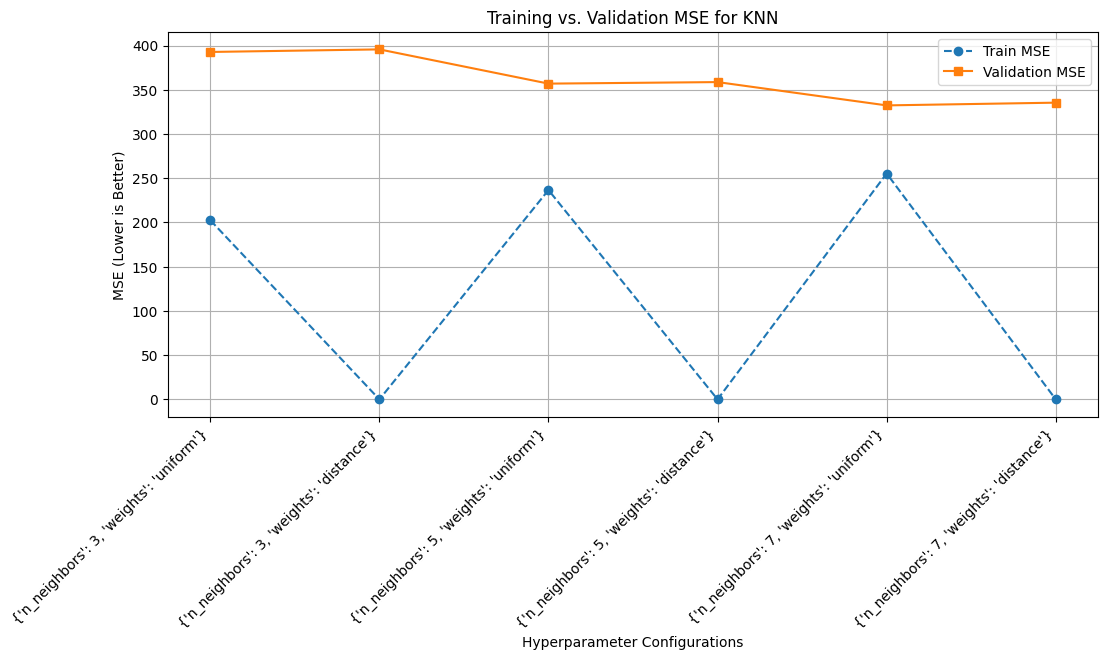

In [ ]:
for model_name, scores in training_vs_validation.items():
    train_errors = scores["train_scores"]
    val_errors = scores["val_scores"]
    param_configs = [str(p) for p in scores["params"]]  # Convert hyperparameters to readable format

    plt.figure(figsize=(12, 5))
    plt.plot(param_configs, train_errors, label="Train MSE", linestyle="--", marker="o")
    plt.plot(param_configs, val_errors, label="Validation MSE", marker="s")

    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
    plt.xlabel("Hyperparameter Configurations")
    plt.ylabel("MSE (Lower is Better)")
    plt.title(f"Training vs. Validation MSE for {model_name}")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
print("Final Model Selection:")
print(results_df)

# Identify the best model based on validation performance
best_model = results_df.iloc[0]  # Top row (lowest MSE)
print("\nBest Model:\n", best_model)

# Print overall conclusion
print("\n🔍 **Overall Training Phase Conclusions:**")
print("- Best Model:", best_model["model"], "with parameters:", best_model["best_params"])
print("- Lowest Cross-Validated MSE:", best_model["best_cv_mse"])
print("- Training Time Comparison:")
print(results_df[["model", "training_time_sec"]].sort_values(by="training_time_sec"))


Final Model Selection:
              model                                        best_params  \
2             Ridge                                     {'alpha': 0.1}   
3             Lasso                                   {'alpha': 0.001}   
1  PolynomialLinear                                {'poly__degree': 1}   
0  LinearRegression                                                 {}   
5      RandomForest  {'max_depth': 5, 'min_samples_leaf': 5, 'n_est...   
6  GradientBoosting  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
7               SVR      {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}   
8               KNN           {'n_neighbors': 7, 'weights': 'uniform'}   
4      DecisionTree           {'max_depth': 3, 'min_samples_split': 2}   

   best_cv_mse  training_time_sec  
2   282.355185           0.050086  
3   282.363361           0.050727  
1   282.364894           0.863303  
0   282.364894           1.130705  
5   305.733545           2.011626  
6   310.017115      

---

# Results with Test

Requirement: Results comparing test (and w/ training/validation) datasets, and analyzing/checking problematic issues (e.g., overfitting) or/and Takeaways (overall conclusions in test phase). 

In [ ]:
# 1) Identify best model from the results DataFrame
best_model_name = results_df.iloc[0]["model"]
best_model_instance = best_estimators[best_model_name]

print(f"Best model based on CV MSE: {best_model_name}")
print("Best hyperparameters:", results_df.iloc[0]["best_params"])
print("Best CV MSE:", results_df.iloc[0]["best_cv_mse"])

# 2) Evaluate on TRAIN set
y_train_pred = best_model_instance.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)

# 3) Evaluate on TEST set
y_test_pred = best_model_instance.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

print("\n--- Performance Comparison ---")
print(f"Train MSE: {train_mse:.2f}")
print(f"Val MSE (Cross-Validation): {results_df.iloc[0]['best_cv_mse']:.2f}")
print(f"Test MSE: {test_mse:.2f}")


Best model based on CV MSE: Ridge
Best hyperparameters: {'alpha': 0.1}
Best CV MSE: 282.3551852533503

--- Performance Comparison ---
Train MSE: 277.52
Val MSE (Cross-Validation): 282.36
Test MSE: 207.10


## Conclusion

- **Best Model**: After systematically comparing multiple estimators via GridSearchCV, **Ridge** regression with `alpha = 0.1` emerged as the top performer based on cross-validation (CV) MSE.
- **Performance Summary**:
        - **Training MSE**: 277.52
        - **Validation MSE (CV)**: 282.36
        - **Test MSE**: 207.10

Interestingly, the **test MSE** is **lower** than both the training and validation MSE. This can happen if the test set is slightly easier or not fully representative of the complexity in the training data. Nonetheless, the close alignment of training and validation MSE suggests **no major overfitting**. Overall, **Ridge** with `alpha = 0.1` generalizes well to unseen data, making it the most suitable choice among the tested models.

**Next Steps**:
- Consider further validation with more data or alternate splits to ensure consistency.
- Investigate potential reasons why the test set yielded a lower MSE than training/validation (e.g., differences in distribution, random variance, or smaller test sample).
- If needed, explore refined hyperparameter grids or additional ensemble methods for potential incremental gains.
